## Imports: standard libraries, data processing & visualization


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import warnings
import matplotlib
from statsmodels.tsa.stattools import adfuller
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from multiprocessing import Pool, cpu_count
warnings.filterwarnings('ignore')


In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## Data Extraction, Processing & Visualization
- Load external file containing historical hourly electricity prices in day-ahead market from 2019-2023
- Load external file containing historical gas prices traded at Title Transfer Facility (TTF) from 2019-2023
- Load external file containing electricity and gas prices in 2024 to make comparisons with the forecasts
- For personal reference, the data for electricity and gas prices is available on investing.com

In [3]:
#Extract the Excel file to a Pandas dataframe to perform further operations
df = pd.read_excel("2024_historic_dayahead_price_DE.xlsx", sheet_name=0, parse_dates=['Datum']).set_index('Datum').sort_index()


#reindex to hourly to ensure uniform spacing, interpolate if required
df = df.asfreq('H')
if df['Preis'].isna().sum() > 0:
    df['Preis'] = df['Preis'].interpolate(method='time', limit=24)

df['Hour'] = df.index.hour

df['dayofweek'] = df.index.dayofweek

df['Month'] = df.index.month

df['Year'] = df.index.year

#Import gas price data from TTF historical dataset. This will be used as an eXogenous variable
gas = pd.read_csv("Dutch-TTF-Hourly-Aligned.csv", parse_dates=['DateTime'])
gas = gas.set_index('DateTime').asfreq('H')

#Join both the data
data = df.join(gas.rename(columns={'Price': 'gas_price'}), how='left')

#Create a fake crisis data to detect the crisis period
data['crisis'] = ((data.index >= '2022-01-01') & (data.index < '2023-12-31')).astype(int)
data['covid_crisis'] = ((data.index >= '2021-07-01') & (data.index < '2022-01-01')).astype(int)

# Create Exogenous Variables
- These exogenous variables will help the model catch short-term to seasonal effects more accurately
- The snippet below creates several exogenous variables and tests them against the forecasts
- Adjust or remove the variables according to personal requirements
- More variables demand more processing time for the SARIMAX model

In [5]:
#Variable to create the impact of the weekend
data['weekend_effect'] = (data['dayofweek'] <= 5).astype(int)

#Varialbe to notice hours of the weekend
data['weekend_evening'] = ((data['dayofweek'] >= 5) & (data['Hour'] >= 18)).astype(int)
data['weekend_morning'] = ((data['dayofweek'] >= 5) & (data['Hour'] <= 10)).astype(int)

#Capture oscillatory trend in the daily routine
data['dayofweek_sin'] = np.sin(2 * np.pi * (data['dayofweek'] + 1)/7) # +1 for tuesday peak
data['dayofweek_cos'] = np.cos(2 * np.pi * (data['dayofweek'] + 1)/7)

#Is the day Saturday or Sunday?
data['Sunday'] = (data['dayofweek'] == 6).astype(int)
data['Saturday'] = (data['dayofweek'] == 5).astype(int)


# exog = data[["gas_price", "crisis", "weekend_evening", "weekend_effect",
#              "weekend_morning"]]   # , "dayofweek_sin", "dayofweek_cos"


def create_crisis_intensity(index):
    crisis_intensity = np.zeros(len(index)) 
    
    # January 2022 pre-crisis peak
    jan_feb_2022 = (index >= '2022-01-01') & (index <= '2022-02-28')
    crisis_intensity[jan_feb_2022] = 3 * 0.75
    
    # March 2022 peak (highest intensity)
    march_peak = (index >= '2022-03-01') & (index <= '2022-03-31')
    crisis_intensity[march_peak] = 4 * 1.0
    
    # August 2022 peak (highest intensity)
    august_peak = (index >= '2022-08-01') & (index <= '2022-08-31')
    crisis_intensity[august_peak] = 2 * 1.0
    
    # April-July 2022 (medium-high intensity)
    spring_summer = (index >= '2022-04-01') & (index <= '2022-07-31')
    crisis_intensity[spring_summer] = 4 * 0.85
    
    # September-December 2022 (medium intensity)
    autumn = (index >= '2022-09-01') & (index <= '2022-12-31')
    crisis_intensity[autumn] = 4 * 0.8
    
    # 2023 - gradual decline
    early_2023 = (index >= '2023-01-01') & (index <= '2023-03-31')
    crisis_intensity[early_2023] = 2 * 0.75
    
    mid_2023 = (index >= '2023-04-01') & (index <= '2023-06-30')
    crisis_intensity[mid_2023] = 2 * 0.7
    
    late_2023 = (index >= '2023-07-01') & (index <= '2023-12-31')
    crisis_intensity[late_2023] = 2 * 0.65
    
    return crisis_intensity


data['crisis_intensity'] = create_crisis_intensity(data.index)

def create_duck_curve_features(hour):
    #Create features that capture the duck curve shape
    
    #Morning peak (8:00) - normalized to 1.0
    morning_peak = np.exp(-((hour - 8) / 1.5) ** 2)
    
    #Noon solar dip (13:00) - normalized to 0.3 of morning peak
    solar_dip = 0.5 * np.exp(-((hour - 13) / 2.0) ** 2)
    
    #Evening peak (18:30) - normalized to 1.1 of morning peak
    evening_peak = 1.15 * np.exp(-((hour - 18.5) / 1.5) ** 2)
    
    #Base daily pattern (combining all components)
    duck_curve = morning_peak - solar_dip + evening_peak
    
    #Individual components 
    return {
        'duck_curve_base': duck_curve,
        'morning_peak': morning_peak,
        'solar_dip': solar_dip,
        'evening_peak': evening_peak,
        'off_peak_night': np.exp(-((hour - 2) / 3.0) ** 2)  # Night trough
    }

#Apply duck curve features
duck_features = pd.DataFrame([create_duck_curve_features(h) for h in data['Hour']], 
                            index=data.index)

data = pd.concat([data, duck_features], axis=1)

def create_weekly_pattern(dayofweek):
    #Base prices relative to Tuesday (highest)
    weekday_base = {
        0: 0.90,  # Monday (slightly lower than Tuesday)
        1: 1.00,  # Tuesday (highest)
        2: 0.975, # Wednesday 
        3: 0.950, # Thursday
        4: 0.925, # Friday
        5: 0.89, # Saturday (25% drop from Friday: 0.908 * 0.75 ≈ 0.681)
        6: 0.86  # Sunday (15% drop from Saturday: 0.658 * 0.85 ≈ 0.559)
    }
    
    return weekday_base[dayofweek]

# Apply weekly pattern
data['weekly_pattern'] = data['dayofweek'].map(create_weekly_pattern)

# # Additional weekly features for flexibility
# data['is_tuesday'] = (data['dayofweek'] == 1).astype(int)
data['is_weekend'] = (data['dayofweek'] >= 5).astype(int)
data['weekend_intensity'] = data['is_weekend'] * data['weekly_pattern']

def create_seasonal_features(month):
    # Seasonal multipliers (Summer = 1.0 as baseline)
    seasonal_multiplier = {
        1: 0.85,   # January (Winter) - 15% lower than Summer
        2: 0.85,   # February (Winter)
        3: 0.78,   # March (Spring) - 7% lower than Winter
        4: 0.78,   # April (Spring)
        5: 0.78,   # May (Spring)
        6: 1.00,   # June (Summer) - baseline
        7: 1.00,   # July (Summer)
        8: 1.00,   # August (Summer)
        9: 0.95,   # September (Autumn) - 5% lower than Summer
        10: 0.95,  # October (Autumn)
        11: 0.95,  # November (Autumn)
        12: 0.85   # December (Winter)
    }
    
    return seasonal_multiplier[month]

# Apply seasonal pattern
data['seasonal_multiplier'] = data['Month'].map(create_seasonal_features)

# # Additional seasonal features
# season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter',
#               3: 'Spring', 4: 'Spring', 5: 'Spring',
#               6: 'Summer', 7: 'Summer', 8: 'Summer',
#               9: 'Autumn', 10: 'Autumn', 11: 'Autumn'}

# data['Season'] = data['Month'].map(season_map)

# # Seasonal dummies for flexibility
# data['is_summer'] = (data['Season'] == 'Summer').astype(int)
# data['is_spring'] = (data['Season'] == 'Spring').astype(int)
# data['is_autumn'] = (data['Season'] == 'Autumn').astype(int)
# data['is_winter'] = (data['Season'] == 'Winter').astype(int)

#Interaction Terms between the exog variables

# Interaction between daily duck curve and weekly pattern
data['duck_weekly_interaction'] = duck_features['duck_curve_base'] * data['weekly_pattern']

# Interaction between crisis and seasonal effects
data['crisis_seasonal_interaction'] = data['crisis_intensity'] * data['seasonal_multiplier']

# Interaction between weekly pattern and gas prices
data["gas_weekly_interaction"] = data["gas_price"] * data["weekly_pattern"]

- Assign the dictionary "exog" that stores the keys corresponding to the exogenous features

In [6]:
exog = data[["gas_price", "seasonal_multiplier", "weekly_pattern", "weekend_effect", "crisis", "crisis_intensity"]]  #add more if needed

# exog_2 = data[["gas_price", "weekly_pattern", "seasonal_multiplier", "crisis_intensity", "weekend_effect"]]#, "weekly_pattern", "seasonal_multiplier", "weekend_effect", "crisis"]]

# Create forecast exogenous variables (for 2024)
- Same features as above, but for a different time interval
- Will be used to make actual hourly forecasts
- Data is downloaded from investing.com and interpolated from daily to hourly frequency

In [7]:
#import gas price for 2024
df_2024 = pd.read_csv('2024_ttf_aligned.csv', parse_dates=['Date']).set_index('Date').sort_index()
if df_2024.index.has_duplicates:
    # Option 1: Keep the first occurrence
    df_2024 = df_2024[~df_2024.index.duplicated(keep='first')]
    # Option 2 (better if averaging makes sense):
    # df_2024 = df_2024.groupby(df_2024.index).mean()
# reindex to hourly to ensure uniform spacing, interpolate if required
df_2024 = df_2024.asfreq('H')

if df_2024['Price'].isna().sum() > 0:
    df_2024['Price'] = df_2024['Price'].interpolate(method='time', limit=24)
    
df_2024 = df_2024.rename(columns={'Price': 'gas_price'})


df_2024['Hour'] = df_2024.index.hour

df_2024['dayofweek'] = df_2024.index.dayofweek

df_2024['Month'] = df_2024.index.month

df_2024['Year'] = df_2024.index.year

#Variable to create the impact of the weekend
df_2024['weekend_effect'] = (df_2024['dayofweek'] <= 5).astype(int)

#Varialbe to notice hours of the weekend
df_2024['weekend_evening'] = ((df_2024['dayofweek'] >= 5) & (df_2024['Hour'] >= 18)).astype(int)
df_2024['weekend_morning'] = ((df_2024['dayofweek'] >= 5) & (df_2024['Hour'] <= 10)).astype(int)

#Capture oscillatory trend in the daily routine
df_2024['dayofweek_sin'] = np.sin(2 * np.pi * (df_2024['dayofweek'] + 1)/7)
df_2024['dayofweek_cos'] = np.cos(2 * np.pi * (df_2024['dayofweek'] + 1)/7)

#Is the day Saturday or Sunday?
df_2024['Sunday'] = (df_2024['dayofweek'] == 6).astype(int)
df_2024['Saturday'] = (df_2024['dayofweek'] == 5).astype(int)

df_2024['crisis'] = ((df_2024.index >= '2022-02-01') & (df_2024.index < '2022-12-31')).astype(int)

df_2024["crisis_intensity"] = create_crisis_intensity(df_2024.index)
df_2024['covid_crisis'] = ((df_2024.index >= '2021-07-01') & (df_2024.index < '2022-01-01')).astype(int)
# Apply duck curve features
duck_features_2024 = pd.DataFrame([create_duck_curve_features(h) for h in df_2024['Hour']], 
                            index=df_2024.index)

df_2024 = pd.concat([df_2024, duck_features_2024], axis=1)

# Apply weekly pattern
df_2024['weekly_pattern'] = df_2024['dayofweek'].map(create_weekly_pattern)
df_2024['is_weekend'] = (df_2024['dayofweek'] >= 5).astype(int)
df_2024['weekend_intensity'] = df_2024['is_weekend'] * df_2024['weekly_pattern']

# Apply seasonal pattern
df_2024['seasonal_multiplier'] = df_2024['Month'].map(create_seasonal_features)

#Interaction Terms between the exog variables

# Interaction between daily duck curve and weekly pattern
df_2024['duck_weekly_interaction'] = duck_features_2024['duck_curve_base'] * df_2024['weekly_pattern']

# Interaction between crisis and seasonal effects
df_2024['crisis_seasonal_interaction'] = df_2024['crisis_intensity'] * df_2024['seasonal_multiplier']

# Interaction between weekly pattern and gas prices
df_2024["gas_weekly_interaction"] = df_2024["gas_price"] * df_2024["weekly_pattern"]



exog_2024 = df_2024[["gas_price", "seasonal_multiplier", "weekly_pattern", "weekend_effect", "crisis", "crisis_intensity"]]  #add more if needed

# exog_2024_2 = df_2024[["gas_price", "weekly_pattern", "seasonal_multiplier", "crisis_intensity", "weekend_effect"]]#, "weekly_pattern", "seasonal_multiplier", "weekend_effect", "crisis"]]

##Join 2019-2023 exo dataframe with 2024 dataframe
# exog_combined = pd.concat([exog, exog_2024])


# Check stationarity of electricity prices
- A time series data needs to be stationary in order for ARIMA model to work
- There are no such restrictions for SARIMA and SARIMAX models
- However, it's a good practice to check for the stationarity of a time series data

In [6]:
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("stationary series")
    else:
        print("non-stationary series")

check_stationarity(data['Preis'])

ADF Statistic: -7.378864
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
stationary series


# Model Diagnostics and Best fit parameters

- Grid Search to explore the parameter space
- The parameter set with the lowest AIC (Akaike Information Criterion) is the best-fit

In [ ]:
# Set up parameter grids
p = d =q =range(0, 2)
P = D =Q =range(0, 2)
s =24  

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

param_grid = list(itertools.product(pdq, seasonal_pdq))

def sarimax_gridsearch(params, y):
    order, seasonal_order = params
    try:
        mod = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False)
        results = mod.fit(disp=False)
        return {'order': order, 'seasonal_order': seasonal_order, 'aic': results.aic}
    except Exception as e:
        return None

#To save time, parallelize the task over several CPU cores
results = Parallel(n_jobs=10)(delayed(sarimax_gridsearch)(params, train_data["Preis"]) for params in param_grid)

#find the best result among all teh computed results
results = [res for res in results if res is not None]
best_result = min(results, key=lambda x: x['aic'])

print(f"Best SARIMAX order: {best_result['order']}, seasonal_order: {best_result['seasonal_order']}, AIC: {best_result['aic']}")

# Train Test split data & Exo Variables

- This is the first & simplest backtesting strategy
- Create a fixed split of the full data into training data and test data
- Create the SARIMAX Forecasting model

In [8]:
train_stop_date = '2019-06-30'
test_stop_date = "2019-07-31"
train_data = data.loc[:train_stop_date]
test_data = data.loc[train_stop_date:test_stop_date]

exog_train = exog.loc[train_data.index]
exog_test = exog.loc[test_data.index]

model = SARIMAX(
    train_data['Preis'],
    exog=exog_train, 
    order=(1,0,3),        # ARIMA(p,d,q)  ##use ACF PACF to get robust estimates #(1,0,1)
    seasonal_order=(1,1,1,168),  # seasonal pattern (daily) (1,1,1,48)
    enforce_stationarity=False,
    enforce_invertibility=True
)

results = model.fit(disp=False)
print(results.summary())

# Forecast prices using the model

- Make predictions for the case of a static train-test split backtesting on the test data
- Compute the evaluation metrics such as MAE, MSE, RMSE

In [ ]:
forecast = results.get_forecast(steps=len(test_data), exog=exog_test) #, exog=exog_test
pred_prices = forecast.predicted_mean

#Evaluation metrics for forecasted data
mae_test = mean_absolute_error(test_data['Preis'], pred_prices)
mse_test = mean_squared_error(test_data['Preis'], pred_prices)
rmse_test = np.sqrt(mse_test)
print("For the test data the evaluation metrics are:\n")
print(f"MAE: {mae_test:.2f}")
print(f"MSE: {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")


#Evaluation metrics for training data
mae_train = mean_absolute_error(train_data['Preis'], results.fittedvalues)
mse_train = mean_squared_error(train_data['Preis'], results.fittedvalues)
rmse_train = np.sqrt(mse_train)
print("\nFor the train data the evaluation metrics are:\n")
print(f"MAE: {mae_train:.2f}")
print(f"MSE: {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")

# Visualize Train-Test Split Results
- Save the figures externally
- Option to also plot residuals and the autocorrelation function for advanced analysis
- ACF and PACF plots help in finding the best fit parameters, in complement to the GridSearch

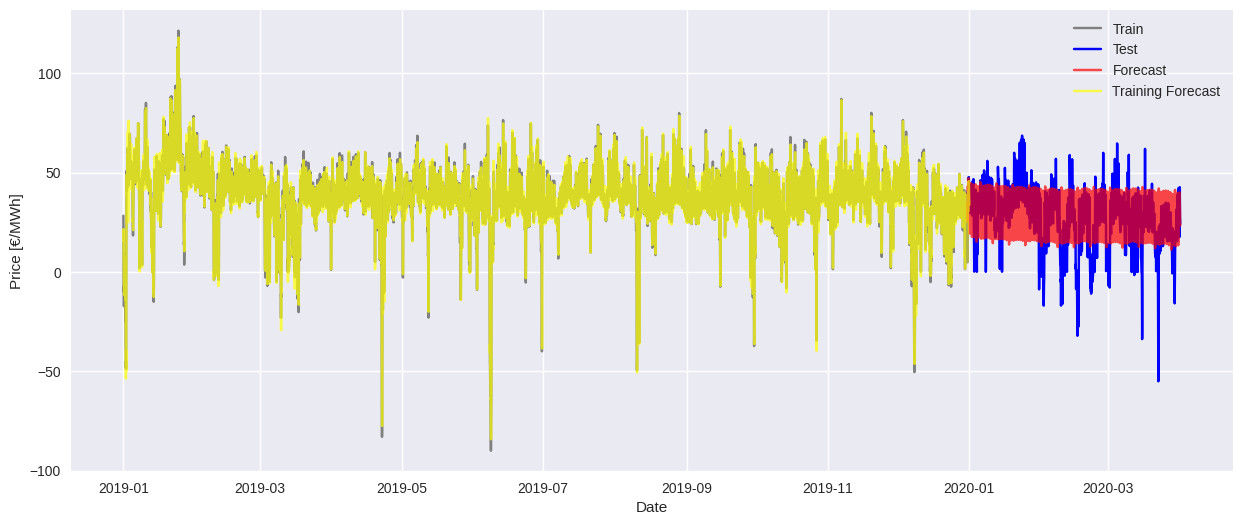

In [57]:
plt.figure(figsize=(15,6))
plt.plot(train_data.index, train_data['Preis'], label='Train', color='gray')
plt.plot(test_data.index, test_data['Preis'], label='Test', color='blue')
plt.plot(test_data.index, pred_prices, label='Forecast', color='red', alpha=0.7)
plt.plot(train_data.index, results.fittedvalues, label='Training Forecast', color='yellow', alpha=0.7)
# plt.xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2020-03-31"))
# plt.ylim(-50,80)
plt.xlabel("Date")
plt.ylabel("Price [€/MWh]")
plt.legend()
# plt.savefig("plots/TT_window/TT_split_BT_12m_3m_Exo.pdf", format="pdf", dpi=300)
plt.show()

# Residuals
# residuals = train_data['Preis'] - results.fittedvalues
# sns.histplot(residuals, kde=True, color='purple')
# plt.title("Residual Distribution (Train Set)")
# plt.savefig("plots/TT_window/TT_split_residuals.pdf", format="pdf", dpi=300)
# plt.show()

#plot ACF for residuals to check if they have a white noise
# plot_acf(residuals)
# plt.show()

# Expanding Window Backtesting

In [27]:
def expanding_window_backtest(
    data, exog,
    start_date, end_date,
    initial_train_days=90, forecast_horizon_days=14,
    order=(1,0,3), seasonal_order=(1,1,3,24),
    maxiter_first=200, maxiter_subsequent=50
):


    #create the date interval of backtest
    data = data.loc[start_date:end_date]
    exog = exog.loc[start_date:end_date]

    forecasts = []
    actuals = []

    initial_end = pd.Timestamp(start_date) + pd.Timedelta(days=initial_train_days)
    forecast_horizon = pd.Timedelta(days=forecast_horizon_days)

    print(f"Starting backtest from {start_date} to {end_date}")
    print(f"Initial training window: {initial_train_days} days")
    print(f"Forecast horizon: {forecast_horizon_days} days")
    print(f"Warm-start enabled (maxiter: first={maxiter_first}, next={maxiter_subsequent})")

    #iteration counter
    total_iterations = 0
    temp_end = initial_end
    while temp_end + forecast_horizon < pd.Timestamp(end_date):
        total_iterations += 1
        temp_end += forecast_horizon

    initial_end = pd.Timestamp(start_date) + pd.Timedelta(days=initial_train_days)

    prev_params = None  # store params from previous fit
    #tqdm provides progress bar of the loop
    for i in tqdm(range(total_iterations), desc="Expanding Window Backtest"):
        #train test split dynamically
        train = data.loc[:initial_end]
        test = data.loc[initial_end: initial_end + forecast_horizon]
        exog_train = exog.loc[train.index]
        exog_test = exog.loc[test.index]

        #sarimax model, choose parameters from gridsearch
        model = SARIMAX(
            train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )

        #fit with or without warm-start
        if prev_params is None:
            results = model.fit(disp=False, maxiter=maxiter_first)
        else:
            try:
                results = model.fit(start_params=prev_params, disp=False, maxiter=maxiter_subsequent)
            except Exception:
                results = model.fit(disp=False, maxiter=maxiter_first)

        #forecast and store the results
        forecast = results.get_forecast(steps=len(test), exog=exog_test)
        pred = forecast.predicted_mean
        forecasts.append(pred)
        actuals.append(test)

        #update the params for warm start to save computing time
        prev_params = results.params

        #new expanded window
        initial_end += forecast_horizon

    #combine all chunks
    forecasts = pd.concat(forecasts)
    actuals = pd.concat(actuals)

    #compute metrics
    mae = mean_absolute_error(actuals, forecasts)
    mse = mean_squared_error(actuals, forecasts)
    rmse = np.sqrt(mse)
    

    metrics = {"MAE": mae, "MSE": mse, "RMSE": rmse}

    return metrics, forecasts, actuals

start_date='2019-01-01'
end_date='2019-07-01'

metrics_2019, forecasts_2019, actuals_2019 = expanding_window_backtest(
    data['Preis'],
    exog,
    start_date=start_date,
    end_date=end_date,
    initial_train_days=30,
    forecast_horizon_days=3,
    order=(1,0,1),
    seasonal_order=(1,1,1,24)
)

print("Expanding Window Backtest Results:")
for k, v in metrics_2019.items():
    print(f"{k}: {v:.3f}")


Starting backtest from 2019-01-01 to 2019-07-01
Initial training window: 30 days
Forecast horizon: 3 days
Warm-start enabled (maxiter: first=200, next=50)


Expanding Window Backtest: 100%|████████████████| 50/50 [45:41<00:00, 54.83s/it]

Expanding Window Backtest Results:
MAE: 8.633
MSE: 190.570
RMSE: 13.805


# Sliding Window Backtesting

- Same code structure as expanding window
- instead of an expanding training set, create a sliding training set

In [72]:
def sliding_window_backtest(
    data, exog,
    start_date, end_date,
    train_window_days=180, forecast_horizon_days=30,
    order=(1,0,3), seasonal_order=(1,1,3,24),
    maxiter_first=200, maxiter_subsequent=50
):


    #training dataset
    data = data.loc[start_date:end_date]
    exog = exog.loc[start_date:end_date]

    forecasts = []
    actuals = []

    start_time = pd.Timestamp(start_date)
    forecast_horizon = pd.Timedelta(days=forecast_horizon_days)

    print(f"Starting SLIDING WINDOW backtest from {start_date} to {end_date}")
    print(f"Training window: {train_window_days} days, Forecast horizon: {forecast_horizon_days} days")
    print(f"Warm-start enabled (maxiter: first={maxiter_first}, next={maxiter_subsequent})")

    #iteration counter
    total_iterations = 0
    temp_start = start_time
    while temp_start + pd.Timedelta(days=train_window_days + forecast_horizon_days) < pd.Timestamp(end_date):
        total_iterations += 1
        temp_start += forecast_horizon

    prev_params = None  #store the warm start to save time

    for i in tqdm(range(total_iterations), desc="Sliding Window Backtest"):
        train_start = start_time + i * forecast_horizon
        train_end = train_start + pd.Timedelta(days=train_window_days)
        test_end = train_end + forecast_horizon

        # Define rolling train/test windows
        train = data.loc[train_start:train_end]
        test = data.loc[train_end:test_end]
        exog_train = exog.loc[train.index]
        exog_test = exog.loc[test.index]

        if len(train) == 0 or len(test) == 0:
            continue

        #sarimax model, choose parameters from gridsearch
        model = SARIMAX(
            train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )

        if prev_params is None:
            results = model.fit(disp=False, maxiter=maxiter_first)
        else:
            try:
                results = model.fit(start_params=prev_params, disp=False, maxiter=maxiter_subsequent)
            except Exception:
                results = model.fit(disp=False, maxiter=maxiter_first)

        #forecast and store the results
        forecast = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean
        forecasts.append(forecast)
        actuals.append(test)

        #update the params for warm start to save computing time
        prev_params = results.params

    #combine all forecasts
    forecasts = pd.concat(forecasts)
    actuals = pd.concat(actuals)

    #compute metrics
    mae = mean_absolute_error(actuals, forecasts)
    mse = mean_squared_error(actuals, forecasts)
    rmse = np.sqrt(mse)

    metrics = {"MAE": mae, "MSE": mse, "RMSE": rmse}

    print("Sliding Window Backtest complete.")

    return metrics, forecasts, actuals



metrics_2019, forecasts_2019, actuals_2019 = sliding_window_backtest(
    data['Preis'],
    exog_combined,
    start_date='2022-01-01',
    end_date='2024-01-01',
    train_window_days=90,     # 6 months of training data
    forecast_horizon_days=1,  # 1 month ahead forecast
    order=(1,0,1),
    seasonal_order=(1,1,1,24)
)

print("Sliding Window Backtest Results:")
for k, v in metrics_2019.items():
    print(f"{k}: {v:.3f}")


Starting SLIDING WINDOW backtest from 2022-01-01 to 2024-01-01
Training window: 90 days, Forecast horizon: 1 days
Warm-start enabled (maxiter: first=200, next=50)


Sliding Window Backtest: 100%|██████████████| 639/639 [8:06:21<00:00, 45.67s/it]

Sliding Window Backtest complete.
Sliding Window Backtest Results:
MAE: 35.540
MSE: 2791.141
RMSE: 52.831


# Save or load the model
- carefully run the save and load feature
- save the dataframes as pickle format
- make sure not to erase existing files or variables

In [87]:
import pickle
#Save
# with open('expanding_BT_2022_2024_90d_1d.pkl', 'wb') as f:
#     pickle.dump({
#         'metrics_2019': metrics_2019,
#         'forecasts_2019': forecasts_2019,
#         'actuals_2019': actuals_2019
#     }, f)

In [39]:
# # Load  
# import pickle
# with open('expanding_BT_2019_60d_7d.pkl', 'rb') as f:
#     data_extract = pickle.load(f)
#     metrics_2019, forecasts_2019, actuals_2019 = data_extract.values()

# Visuals
- Create prediction visuals for the expanding / sliding window backtesting
- Plot the dynamics of evaluation metrics
- For a dynamic backtesting strategy (where training-test data change with time), rolling metrics are better

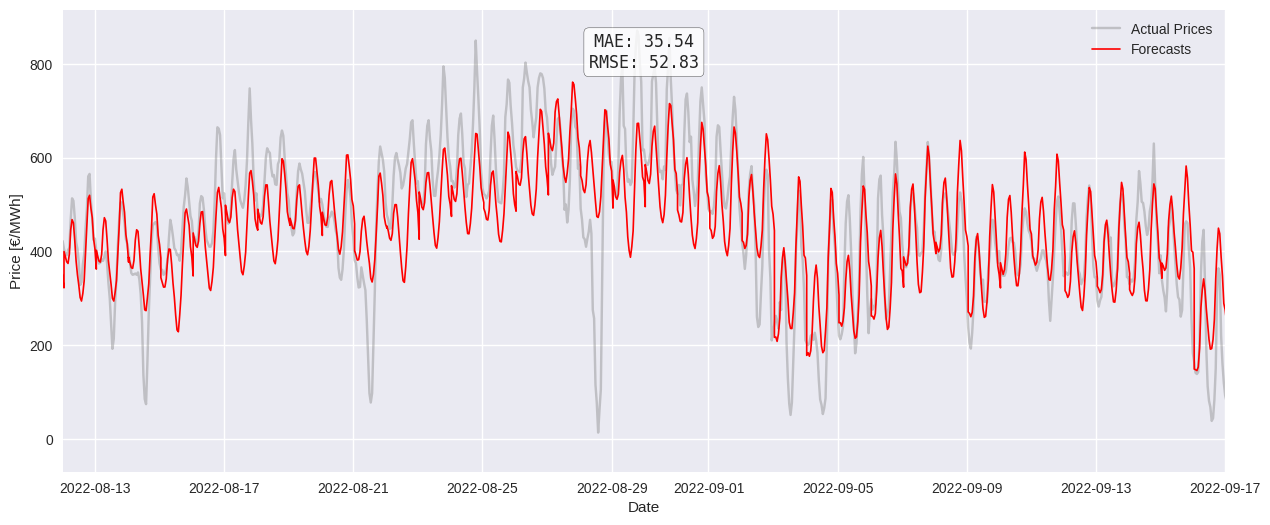

In [93]:
plot_start = '2022-08-12'
plot_end = '2022-09-17'
plt.figure(figsize=(15,6))
plt.plot(data.loc[plot_start:plot_end].index, data.loc[plot_start:plot_end]['Preis'],
         color='gray', alpha=0.4, label='Actual Prices')
plt.plot(forecasts_2019.index, forecasts_2019, color='red', linewidth=1.2, label='Forecasts')

# Add text block at top center
text_str = f'MAE: {metrics_2019["MAE"]:.2f}\nRMSE: {metrics_2019["RMSE"]:.2f}'
plt.text(0.5, 0.95, text_str, transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', horizontalalignment='center',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         fontfamily='monospace')

plt.xlabel("Date")
plt.ylabel("Price [€/MWh]")
plt.xlim(pd.Timestamp(plot_start), pd.Timestamp(plot_end))
plt.legend()
# plt.savefig("plots/expanding_window/expanding_window_BT_1yr_60d_7d.pdf", format="pdf", dpi=300)
plt.show()

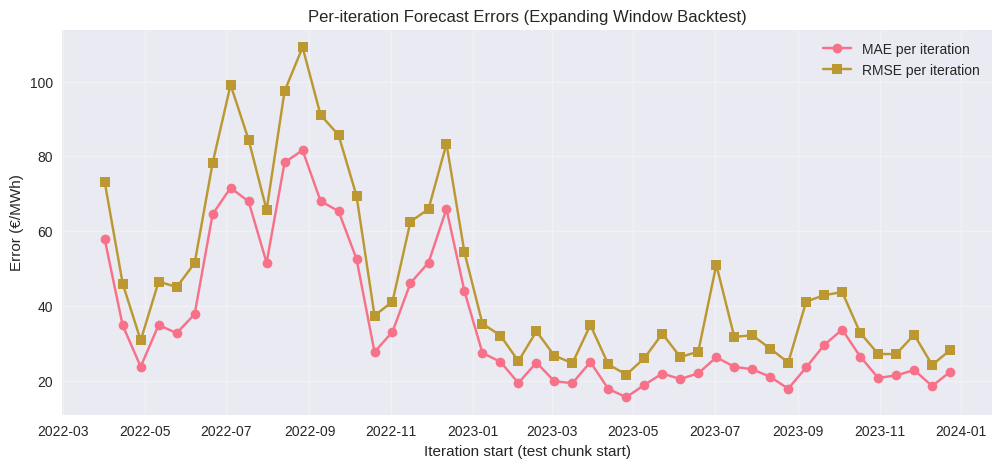

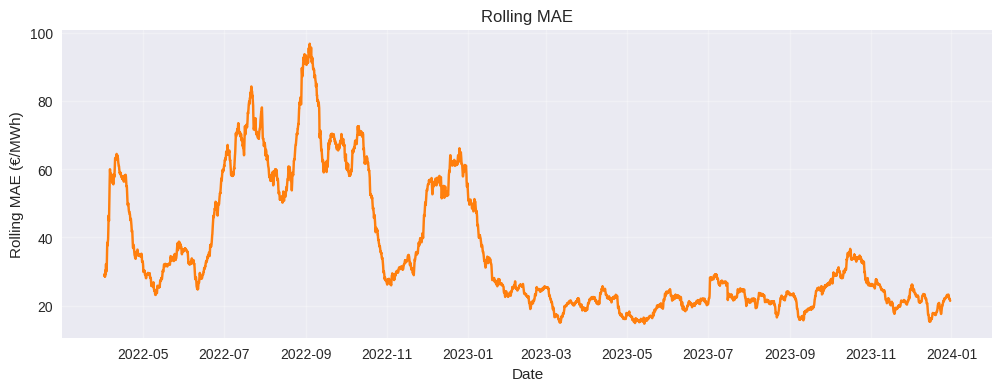

Per-iteration MAE (summary):
count    48.000
mean     35.415
std      18.849
min      15.570
25%      21.785
50%      26.353
75%      47.473
max      81.644
dtype: float64

Global aggregated MAE (backtest): 35.540322969531125


In [98]:

#sort the indices in order
forecasts = forecasts_2019.sort_index()
actuals = actuals_2019.sort_index()

#create forecast horizon and chunk hours
forecast_horizon_days = 14
chunk_hours = forecast_horizon_days * 24

# Convert to numpy arrays for slicing (preserve index separately)
f_vals = forecasts.values
a_vals = actuals.values
f_idx = forecasts.index
a_idx = actuals.index

#find number of chunks after slicing
n_full = len(f_vals) // chunk_hours

mae_list = []
mse_list = []
chunk_start_dates = []

for i in range(n_full):
    s = i * chunk_hours
    e = s + chunk_hours
    f_block = f_vals[s:e]
    a_block = a_vals[s:e]
    mae_block = mean_absolute_error(a_block, f_block)
    mse_block = mean_squared_error(a_block, f_block)
    mae_list.append(mae_block)
    mse_list.append(mse_block)

    chunk_start_dates.append(pd.to_datetime(a_idx[s]))


rem = len(f_vals) - n_full * chunk_hours
if rem > 0:
    s = n_full * chunk_hours
    f_block = f_vals[s:]
    a_block = a_vals[s:]
    mae_block = mean_absolute_error(a_block, f_block)
    mse_block = mean_squared_error(a_block, f_block)
    mae_list.append(mae_block)
    mse_list.append(mse_block)
    chunk_start_dates.append(pd.to_datetime(a_idx[s]))


mae_series = pd.Series(mae_list, index=chunk_start_dates)
mse_series = pd.Series(mse_list, index=chunk_start_dates)

#Plot MAE and MSE as a func of number of iterations
plt.figure(figsize=(12,5))
plt.plot(mae_series.index, mae_series.values, marker='o', label='MAE per iteration')
plt.plot(mse_series.index, np.sqrt(mse_series.values), marker='s', label='RMSE per iteration')
plt.title('Per-iteration Forecast Errors (Expanding Window Backtest)')
plt.xlabel('Iteration start (test chunk start)')
plt.ylabel('Error (€/MWh)')
plt.legend()
plt.grid(alpha=0.3)
# plt.savefig("plots/expanding_window/expanding_window_per_iteration_evaluation_1yr_60d_7d.pdf", format="pdf", dpi=300)
plt.show()

# Smoothed rolling MAE across all hourly errors (window = 14 days)
hourly_abs_errors = np.abs(a_vals - f_vals)
hourly_errors_series = pd.Series(hourly_abs_errors, index=a_idx)

# rolling window in hours
rolling_window_hours = 14 * 24
rolling_mae = hourly_errors_series.rolling(rolling_window_hours, min_periods=24).mean()

plt.figure(figsize=(12,4))
plt.plot(rolling_mae.index, rolling_mae.values, color='tab:orange')
plt.title(f'Rolling MAE')
plt.xlabel('Date')
plt.ylabel('Rolling MAE (€/MWh)')
plt.grid(alpha=0.3)
# plt.savefig("plots/expanding_window/expanding_window_rolling_evaluation_1yr_60d_7d.pdf", format="pdf", dpi=300)
plt.show()

#summary of the evaluation
print("Per-iteration MAE (summary):")
print(mae_series.describe().round(3))
print("\nGlobal aggregated MAE (backtest):", mean_absolute_error(actuals, forecasts))


# Perform Actual Forecasts
- Parallelized the models over different CPUs
- Increases runtime up to 2x if forecasting using two separate models
- Warning for memory overflow: The notebook may crash for a longer period
- Use feature "low_memory = True" in model.fit
- Optional feature to winsorize the data before feeding to the model

In [16]:
### Winsorizing to clip extreme outliers in the price dataset

upper, lower = np.percentile(data["Preis"], [5,95])
data["Preis_winsorized"] = np.clip(data["Preis"], lower, upper)
# data["Preis"].plot()
# data["Preis_winsorized"].plot()

In [8]:
CALENDAR_YEAR_PRICE = 85  # €/MWh (scaling target)
FORECAST_YEAR = 2024
N_CORES = min(2, cpu_count())  # use 2 cores (one for each model)

#single function for training and forecasting, will be run on parallel cpus

def train_and_forecast_model(model_name, train_data, exog_train, exog_forecast):

    print(f"Training {model_name}...")

    #tune the hyperparameters from gridsearch
    order = (1, 0, 1)
    seasonal_order = (1, 1, 1, 24)  #weekly seasonality

    model = SARIMAX(
        train_data,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    results = model.fit(disp=False, low_memory=True)

    print(f"{model_name} trained successfully.")

    #full year 2024 forecasts
    forecast = results.get_forecast(steps=len(exog_forecast), exog=exog_forecast)
    forecast_mean = forecast.predicted_mean

    #choose 85 arbitrarily to scale the forecast to match the mean to a calendar year comment out the line for unscaled forecasts
    scaled_forecast = forecast_mean * (CALENDAR_YEAR_PRICE / forecast_mean.mean())

    return {
        "model_name": model_name,
        "forecast": forecast_mean,# scaled_forecast,
        "forecast_scaled": scaled_forecast,
        "results": results
    }

#training data

train_A_mask = (data.index.year >= 2022) & (data.index.year <= 2023)
train_B_mask = (data.index.year >= 2023) & (data.index.year <= 2023)

prices_A = data['Preis'][train_A_mask] # data["Preis_winsorized"][train_A_mask]
prices_B = data['Preis'][train_B_mask] # data["Preis_winsorized"][train_B_mask]

exog_A = exog.loc[prices_A.index]
exog_B = exog_2.loc[prices_B.index] #exog.loc[prices_B.index]

#run training of model A and model B in parallel
models_to_train = [
    ("Model A (2022–2023)", prices_A, exog_A, exog_2024),
    ("Model B (2023–2023) other exo", prices_B, exog_B, exog_2024_2)    #exog_2024
]

with Pool(processes=N_CORES) as pool:
    results_list = pool.starmap(train_and_forecast_model, models_to_train)

#store the forecasts
forecast_A, forecast_A_scaled = results_list[0]["forecast"], results_list[0]["forecast_scaled"]
forecast_B, forecast_B_scaled = results_list[1]["forecast"], results_list[1]["forecast_scaled"]


Training Model A (2022–2023)...
Training Model B (2023–2023) other exo...
Model B (2023–2023) other exo trained successfully.
Model A (2022–2023) trained successfully.



--- Diagnostics for Model A (2021–2023) ---
                                     SARIMAX Results                                      
Dep. Variable:                              Preis   No. Observations:                43824
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -169381.556
Date:                            Thu, 23 Oct 2025   AIC                         338785.111
Time:                                    08:58:49   BIC                         338880.666
Sample:                                01-01-2019   HQIC                        338815.230
                                     - 12-31-2023                                         
Covariance Type:                           approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
gas_price               0.1516      0.051      2.94

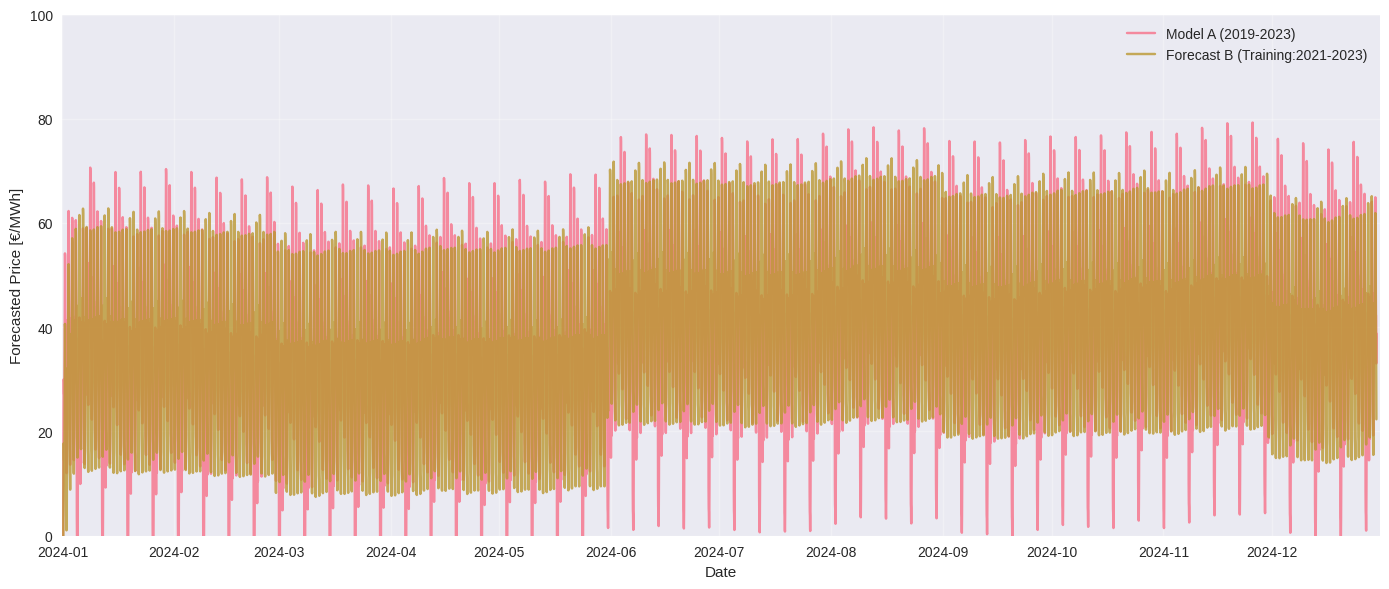

In [36]:
#visuals for the actual forecasts

plot_start = '2024-01-01'
plot_end = '2024-12-31'

actual_2024 = pd.read_csv('2024_electricity_aligned.csv', parse_dates=['Date']).set_index('Date').sort_index() #actual electricity spot prices in day ahead market
plt.figure(figsize=(14, 6))
plt.plot(forecast_A.index, forecast_A, label="Model A (2019-2023)", alpha=0.8)
plt.plot(forecast_B.index, forecast_B, label="Forecast B (Training:2021-2023)", alpha=0.8)
# plt.plot(forecast_A.index, forecast_B / forecast_A, label="Ratio Model B / Model A")
# plt.plot(data.index, data['Preis'], label='Historical Data')
# plt.plot(actual_2024.index, actual_2024['Price'], label='Actual Price 2024')
# plt.plot(forecast_A.index, forecast_A_scaled, label='Model A (5-year trained)', color='tab:blue')
# plt.plot(forecast_B.index, forecast_B_scaled, label='Forecast (Training:2021-2023)', color='tab:orange')
plt.xlabel("Date")
plt.ylabel("Forecasted Price [€/MWh]")
plt.xlim(pd.Timestamp(plot_start), pd.Timestamp(plot_end))
plt.ylim(0,100)
# plt.yscale('log')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig('plots/forecast_3yr_unscaled_round3.png')
# plt.show()


# #model summary
for res in results_list:
    print(f"\n--- Diagnostics for {res['model_name']} ---")
    print(res["results"].summary())


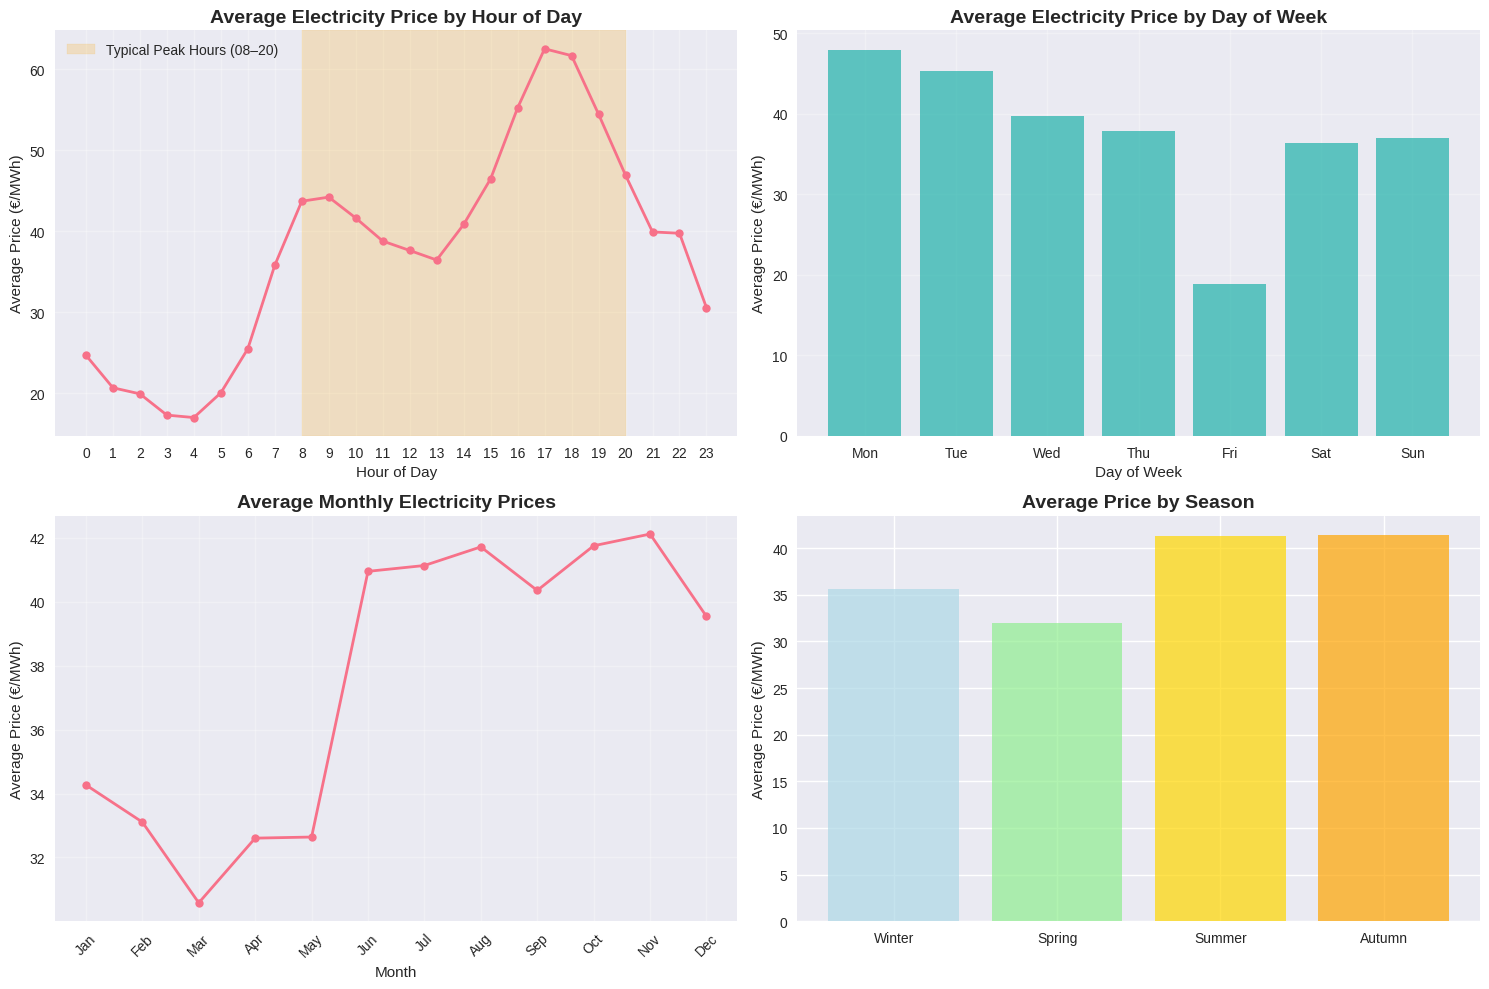

In [37]:
forecast_A_df = forecast_A.reset_index()
forecast_A_df.columns = ['Datum', 'Preis']

plt.figure(figsize=(15, 10))

forecast_A_df['Datum'] = pd.to_datetime(forecast_A_df['Datum'])
forecast_A_df.set_index('Datum', inplace=True)
plt.subplot(2,2,1)
forecast_A_df['Hour'] = forecast_A_df.index.hour
forecast_A_df['Day'] = forecast_A_df.index.day
forecast_A_df['Month'] = forecast_A_df.index.month
forecast_A_df['DayOfWeek'] = forecast_A_df.index.dayofweek  # Monday=0, Sunday=6
forecast_A_df['Weekend'] = forecast_A_df['DayOfWeek'].isin([5, 6]).astype(int)
forecast_A_df['Season'] = forecast_A_df['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                3: 'Spring', 4: 'Spring', 5: 'Spring',
                                6: 'Summer', 7: 'Summer', 8: 'Summer',
                                9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})
hourly_avg = forecast_A_df.groupby('Hour')['Preis'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6)
plt.axvspan(8, 20, color='orange', alpha=0.2, label="Typical Peak Hours (08–20)")
plt.title('Average Electricity Price by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Average Price (€/MWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
# plt.show()

#weekly trend plot
plt.subplot(2, 2, 2)
daily_avg = forecast_A_df.groupby('DayOfWeek')['Preis'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(days, daily_avg.values, color='lightseagreen', alpha=0.7)
plt.title('Average Electricity Price by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Average Price (€/MWh)')
plt.grid(True, alpha=0.3)

#monthly trend plot
plt.subplot(2, 2, 3)
monthly_avg = forecast_A_df.groupby('Month')['Preis'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(months, monthly_avg.values, marker='o', linewidth=2, markersize=6)
plt.title('Average Monthly Electricity Prices', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Price (€/MWh)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

#Seasonal trend plot
plt.subplot(2, 2, 4)
seasonal_avg = forecast_A_df.groupby('Season')['Preis'].mean()

season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_avg = seasonal_avg.reindex(season_order)

plt.bar(seasonal_avg.index, seasonal_avg.values, 
        color=['lightblue', 'lightgreen', 'gold', 'orange'], alpha=0.7)
plt.title('Average Price by Season', fontsize=14, fontweight='bold')
plt.ylabel('Average Price (€/MWh)')

plt.tight_layout()
plt.show()
# plt.savefig("forecast_pattern_2024_scaled_backup.png")
# # Define peak hours (typically 8-20 on weekdays)
# forecast_A_df['Peak'] = ((forecast_A_df['DayOfWeek'] < 5) & (forecast_A_df['Hour'] >= 8) & (forecast_A_df['Hour'] <= 20)).astype(int)
# peak_analysis = forecast_B_df.groupby('Peak')['Preis'].agg(['mean', 'std', 'min', 'max'])
# peak_labels = ['Off-Peak', 'Peak']
# x_pos = range(len(peak_labels))

# plt.bar(x_pos, peak_analysis['mean'], yerr=peak_analysis['std'], 
#         capsize=5, alpha=0.7, color=['skyblue', 'salmon'])
# plt.xticks(x_pos, peak_labels)
# plt.title('Peak vs Off-Peak Price Comparison', fontsize=14, fontweight='bold')
# plt.ylabel('Average Price (€/MWh)')
# plt.show()

In [35]:
#To save the forecasted results from Model A (full data trained) and Model B (last two years data trained)
import pickle

# Save both in one file
# with open('forecasts_2024_Round3_new2_2yr_vs_3yr.pkl', 'wb') as f:
#     pickle.dump({
#         'forecast_A': forecast_A,
#         'forecast_B': forecast_B,
#         'forecast_A_scaled': forecast_A_scaled,
#         'forecast_B_scaled': forecast_B_scaled
#     }, f)


# Load both from single file
# with open('forecasts_2024_Round3_new.pkl', 'rb') as f:
#     data_2024 = pickle.load(f)
#     forecast_A = data_2024['forecast_A']
#     forecast_B = data_2024['forecast_B']
#     forecast_A_scaled = data_2024['forecast_A_scaled']
#     forecast_B_scaled = data_2024['forecast_B_scaled']
    # forecast_A = data_2024['pred_A']
    # forecast_B = data_2024['pred_B']

# (Optional) Extract and Build TTF gas price data

In [45]:
#Load TTF data
#ttf = pd.read_csv('Dutch-TTF-Natural-Gas-Futures-Historical-Data.csv')
ttf = pd.read_csv('DE_2024_daily.csv')#pd.read_csv('2024_ttf_data.csv')

ttf['Date'] = pd.to_datetime(ttf['Date'], errors='coerce')
ttf = ttf.dropna(subset=['Date'])
if 'Price' not in ttf.columns:
    # Guess price column if not named 'Price'
    col = [c for c in ttf.columns if c.lower().startswith('pri')][0]
    ttf = ttf.rename(columns={col: 'Price'})
ttf = ttf[['Date','Price']]

#order the data
if ttf.iloc[0]['Date'] > ttf.iloc[-1]['Date']:
    ttf = ttf.iloc[::-1].reset_index(drop=True)

#some missing days found in the excel file, forward fill them
full_days = pd.date_range(start=ttf['Date'].iloc[0], end=ttf['Date'].iloc[-1], freq='D')
filled = ttf.set_index('Date').reindex(full_days)
filled['Price'] = filled['Price'].fillna(method='ffill')
filled = filled.rename_axis('Date').reset_index()

#change the daily frequency to hourly frequency
hours = pd.date_range(start=filled['Date'].iloc[0], end=filled['Date'].iloc[-1] + timedelta(days=1) - timedelta(hours=1), freq='H')
hourly_df = pd.DataFrame({'DateTime': hours})
hourly_df['Date'] = hourly_df['DateTime'].dt.date
filled['Date'] = pd.to_datetime(filled['Date']).dt.date
hourly_df = hourly_df.merge(filled[['Date','Price']], how='left', left_on='Date', right_on='Date')

# Save 
# hourly_df.to_csv('Dutch-TTF-Hourly-Aligned.csv', index=False)
# hourly_df.to_csv('2024_electricity_aligned.csv', index=False)


In [53]:
#Load TTF and electricity price data
ttf = pd.read_csv('Dutch-TTF-Natural-Gas-Futures-Historical-Data.csv')
power = pd.read_excel('2024_historic_dayahead_price_DE.xlsx')

#find the price and data columns
if 'Date' not in ttf.columns:
    ttf.rename(columns={ttf.columns[0]: 'Date'}, inplace=True)
if 'Price' not in ttf.columns:
    candidates = [c for c in ttf.columns if c.lower().startswith('pri')]
    if candidates:
        ttf.rename(columns={candidates[0]: 'Price'}, inplace=True)
ttf['Date'] = pd.to_datetime(ttf['Date'], errors='coerce')
ttf = ttf.dropna(subset=['Date'])
ttf = ttf[['Date','Price']]
if ttf.iloc[0]['Date'] > ttf.iloc[-1]['Date']:
    ttf = ttf.iloc[::-1].reset_index(drop=True)

#find the date interval of trhe electricity data
power['Datum'] = pd.to_datetime(power['Datum'])
power_min, power_max = power['Datum'].min(), power['Datum'].max()
full_days = pd.date_range(start=power_min.date(), end=power_max.date(), freq='D')

#check and forward fill the missing data
filled = ttf.set_index('Date').reindex(full_days)
filled['Price'] = filled['Price'].fillna(method='ffill')
if pd.isna(filled['Price'].iloc[0]):
    filled['Price'].iloc[0] = filled['Price'].iloc[1]
if pd.isna(filled['Price'].iloc[-1]):
    filled['Price'].iloc[-1] = filled['Price'].iloc[-2]
filled['Price'] = filled['Price'].fillna(method='ffill').fillna(method='bfill')
filled = filled.rename_axis('Date').reset_index()

#convert to the hourly frequency
hours = pd.date_range(start=power_min, end=power_max, freq='H')
hourly_df = pd.DataFrame({'DateTime': hours})
hourly_df['Date'] = hourly_df['DateTime'].dt.date
filled['Date'] = pd.to_datetime(filled['Date']).dt.date
hourly_df = hourly_df.merge(filled, how='left', left_on='Date', right_on='Date')

#Save
# hourly_df.to_csv('Dutch-TTF-Hourly-Aligned-Fixed.csv', index=False)


# Unimportant Code

In [ ]:
shape = df['price'].groupby([df.index.month, df.index.hour]).mean()


shape = shape / shape.mean()


target_year = 2027
rng = pd.date_range(start=f'{target_year}-01-01 00:00:00', end=f'{target_year}-12-31 23:00:00', freq='H')

hp_shape = pd.Series([shape.loc[(ts.month, ts.hour)] for ts in rng], index=rng)

forward_price = 85.0   # set the Cal-27 price manually (e.g. assumed 85 €/MWh)
hpfc = hp_shape * forward_price
# hpfc.to_csv('/mnt/data/hpfc_cal27_85EUR.csv')   # saved example


In [ ]:
model = SARIMAX(
    train_data['Preis'],
    exog=exog_train, 
    order=(1,0,3),        # ARIMA(p,d,q)  ##use ACF PACF to get robust estimates #(1,0,1)
    seasonal_order=(1,1,1,168),  # seasonal pattern (daily) (1,1,1,48)
    enforce_stationarity=False,
    enforce_invertibility=True
)

results = model.fit(disp=False)
print(results.summary())